In [1]:
%load_ext autoreload
%autoreload 2

%env CUDA_VISIBLE_DEVICES 3

env: CUDA_VISIBLE_DEVICES=3


In [25]:
import sys

sys.path.insert(0, '../batchflow')
sys.path.insert(0, '../src')

import numpy as np
import pandas as pd

from batchflow import Pipeline, B, V, I, M, C, plot
from batchflow.models.torch import TorchModel, VGGBlock
from batchflow.models.metrics import ClassificationMetrics
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score
from nbtools.core import get_notebook_name

from loader import ImagesDataset

In [26]:
NAME = get_notebook_name()
NAME

'04_KNN'

In [3]:
SEED = 11
rng = np.random.default_rng(SEED)

In [4]:
DATA_PATH = '../images'
SHAPE = (128, 128, 3)

dataset = ImagesDataset(path=DATA_PATH, encode_labels=True, normalize=True, resize_shape=SHAPE)
n_classes = dataset.label_encoder.classes_.size

dataset.split(shuffle=SEED)

100%|█████████████████████████████████████████████| 9/9 [00:17<00:00,  1.93s/it]


In [5]:
MODEL_PATH = '../models/vgg.torch'
model = TorchModel()
model.load(MODEL_PATH)
penultimate_module = model.model[1][-2]

In [6]:
%%time

predict_template = (
    Pipeline()
    # prepare data
    .to_array(channels='first', dtype=np.float32)
    
    # import trained model
    .import_model('model', model)
    
    # make predictions
    .predict_model(
        name='model', inputs=B('images'),
        outputs=['predictions', 'predicted_proba'],
        save_to=[B('predictions'), B('proba')]
    )
    
    # get penultimate layer activations
    .call(model.get_intermediate_activations, inputs=B('images'),
          layers=penultimate_module, save_to=B('activations'))
)

predict_pipeline_train = predict_template << dataset.train
train_batch = predict_pipeline_train.next_batch(dataset.train.size)

CPU times: user 765 ms, sys: 1.07 s, total: 1.83 s
Wall time: 8.51 s


In [7]:
# images = []
# gradcams = []
# labels = []

# for index in rng.integers(0, dataset.train.size, 4):
#     image = np.transpose(train_batch.images[index], (1, 2, 0))
#     cam = model.get_gradcam(inputs=train_batch.images[index:index+1], layer=penultimate_module)
#     images.append(image.reshape(*image.shape))
#     gradcams.append(cam.reshape(*cam.shape, 1))
#     label = train_batch.labels[index]
#     labels.append(label)

# plot(images, title=labels, combine='separate')
# plot(gradcams, cmap='magma', title=labels, combine='separate')

In [8]:
%%time

n_features = 100
pca = PCA(n_components=n_features, random_state=SEED)
train_features = train_batch.activations.reshape(dataset.train.size, -1)
train_features_reduced = pca.fit_transform(train_features)

CPU times: user 3min 49s, sys: 3min 55s, total: 7min 44s
Wall time: 11.3 s


In [9]:
%%time

clusterer = KMeans(n_clusters=n_classes, random_state=SEED)
train_clustered = clusterer.fit_predict(train_features_reduced)

CPU times: user 1.8 s, sys: 7.73 s, total: 9.53 s
Wall time: 145 ms


In [10]:
formatter = lambda value: f"{int(value * 100)}%"

def evaluate_clustering_metrics(targets, predictions, returns='styled_df'):
    metrics_dict = {}
    metrics_dict['adjusted_rand_score'] = adjusted_rand_score(targets, predictions)
    metrics_dict['adjusted_mutual_info_score'] = adjusted_mutual_info_score(targets, predictions)
    
    if returns in ['df', 'styled_df']:
        metrics_dict = {key: [value] for key, value in metrics_dict.items()}
        df = pd.DataFrame(metrics_dict)
        
        if returns == 'styled_df':
            styled_df = df.style.background_gradient('RdYlGn', vmin=0, vmax=1).format(formatter)
            return styled_df
        
        return df
    
    return metrics_dict

In [11]:
train_labels = train_batch.labels
train_predictions = np.argmax(train_batch.predictions, axis=1)

evaluate_clustering_metrics(train_labels, train_predictions)

,adjusted_rand_score,adjusted_mutual_info_score
0,100%,100%


In [12]:
evaluate_clustering_metrics(train_labels, train_clustered)

,adjusted_rand_score,adjusted_mutual_info_score
0,100%,100%


In [13]:
cluster_to_class = {}

for cluster_num in range(n_classes):
    cluster_classes = train_labels[train_clustered == cluster_num]
    classes_count = np.bincount(cluster_classes, minlength=n_classes)
    
    best_candidate = np.argmax(classes_count)
    cluster_to_class[cluster_num] = best_candidate

    classes_count_repr = ' '.join(str(item).rjust(3, ' ') for item in classes_count)
    print(f"cluster {cluster_num}: [{classes_count_repr}] -> best candidate class: {best_candidate}")

cluster 0: [  0   0   0   0 173   0   0   0] -> best candidate class: 4
cluster 1: [  0   0   0   0   0   0  56   0] -> best candidate class: 6
cluster 2: [  0   0 194   0   0   0   0   0] -> best candidate class: 2
cluster 3: [  0   0   0 161   0   0   0   0] -> best candidate class: 3
cluster 4: [  0   0   0   0   0   0   0 110] -> best candidate class: 7
cluster 5: [  0 293   0   0   0   0   0   0] -> best candidate class: 1
cluster 6: [  0   0   0   0   0  98   0   0] -> best candidate class: 5
cluster 7: [ 53   0   0   0   0   0   0   0] -> best candidate class: 0


In [14]:
%%time

predict_pipeline_test = predict_template << dataset.test
test_batch = predict_pipeline_test.next_batch(dataset.test.size)

test_features = test_batch.activations.reshape(dataset.test.size, -1)
test_features_reduced = pca.transform(test_features)

test_clustered = clusterer.predict(test_features_reduced)

test_labels = test_batch.labels
test_predictions = np.argmax(test_batch.predictions, axis=1)

evaluate_clustering_metrics(test_labels, test_predictions)

CPU times: user 6.83 s, sys: 2.71 s, total: 9.53 s
Wall time: 2.65 s


,adjusted_rand_score,adjusted_mutual_info_score
0,40%,41%


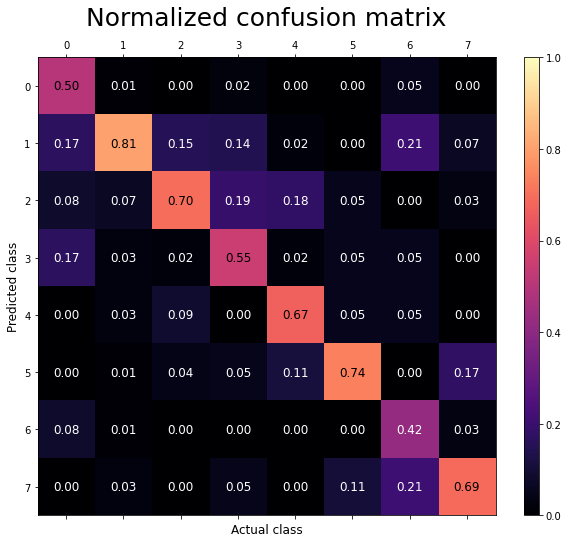

In [15]:
test_clustered_renumerated = np.array(list(map(cluster_to_class.__getitem__, test_clustered)))

metrics = ClassificationMetrics(test_labels, test_clustered_renumerated, fmt='labels', num_classes=n_classes)
metrics.plot_confusion_matrix(normalize=True, vmin=0, vmax=1)

In [16]:
labels, counts = np.unique(dataset.labels[dataset.test.indices], return_counts=True)
shares = counts / counts.sum()

metrics_names = ['precision', 'recall']
metrics_dict = metrics.evaluate(metrics_names, multiclass=None)
metrics_df = pd.DataFrame({'names': dataset.label_encoder.classes_, 'counts': counts, 'shares': shares, **metrics_dict})

formatter = lambda value: f"{int(value * 100)}%"
metrics_df.style.background_gradient('RdYlGn', vmin=0, vmax=1, subset=metrics_names).format(formatter, subset=metrics_names)

,names,counts,shares,precision,recall
0,ArtDeco,12,0.042254,66%,50%
1,Cubism,72,0.253521,72%,80%
2,Impressionism,46,0.161972,57%,69%
3,Japonism,42,0.147887,74%,54%
4,Naturalism,45,0.158451,78%,66%
5,Rococo,19,0.066901,48%,73%
6,cartoon,19,0.066901,72%,42%
7,photo,29,0.102113,66%,68%


In [17]:
metrics_names = ['accuracy', 'f1_score']
metrics_values = [metrics.evaluate(metric_name) for metric_name in metrics_names]

metrics_df = pd.DataFrame(data=metrics_values, index=metrics_names)
metrics_df.T.style.background_gradient('RdYlGn', vmin=0, vmax=1).format(formatter)

,accuracy,f1_score
0,67%,65%


In [27]:
METRICS_PATH = f'../metrics/{NAME}.npy'
all_metrics = {**metrics_dict, **{key: value for key, value in zip(metrics_names, metrics_values)}}
# np.save(METRICS_PATH, all_metrics)

In [19]:
projector = pca.components_
summed = projector.sum(axis=0)
reshaped = summed.reshape(256, 32, 32)
descending = reshaped.argsort(axis=0)[::-1]

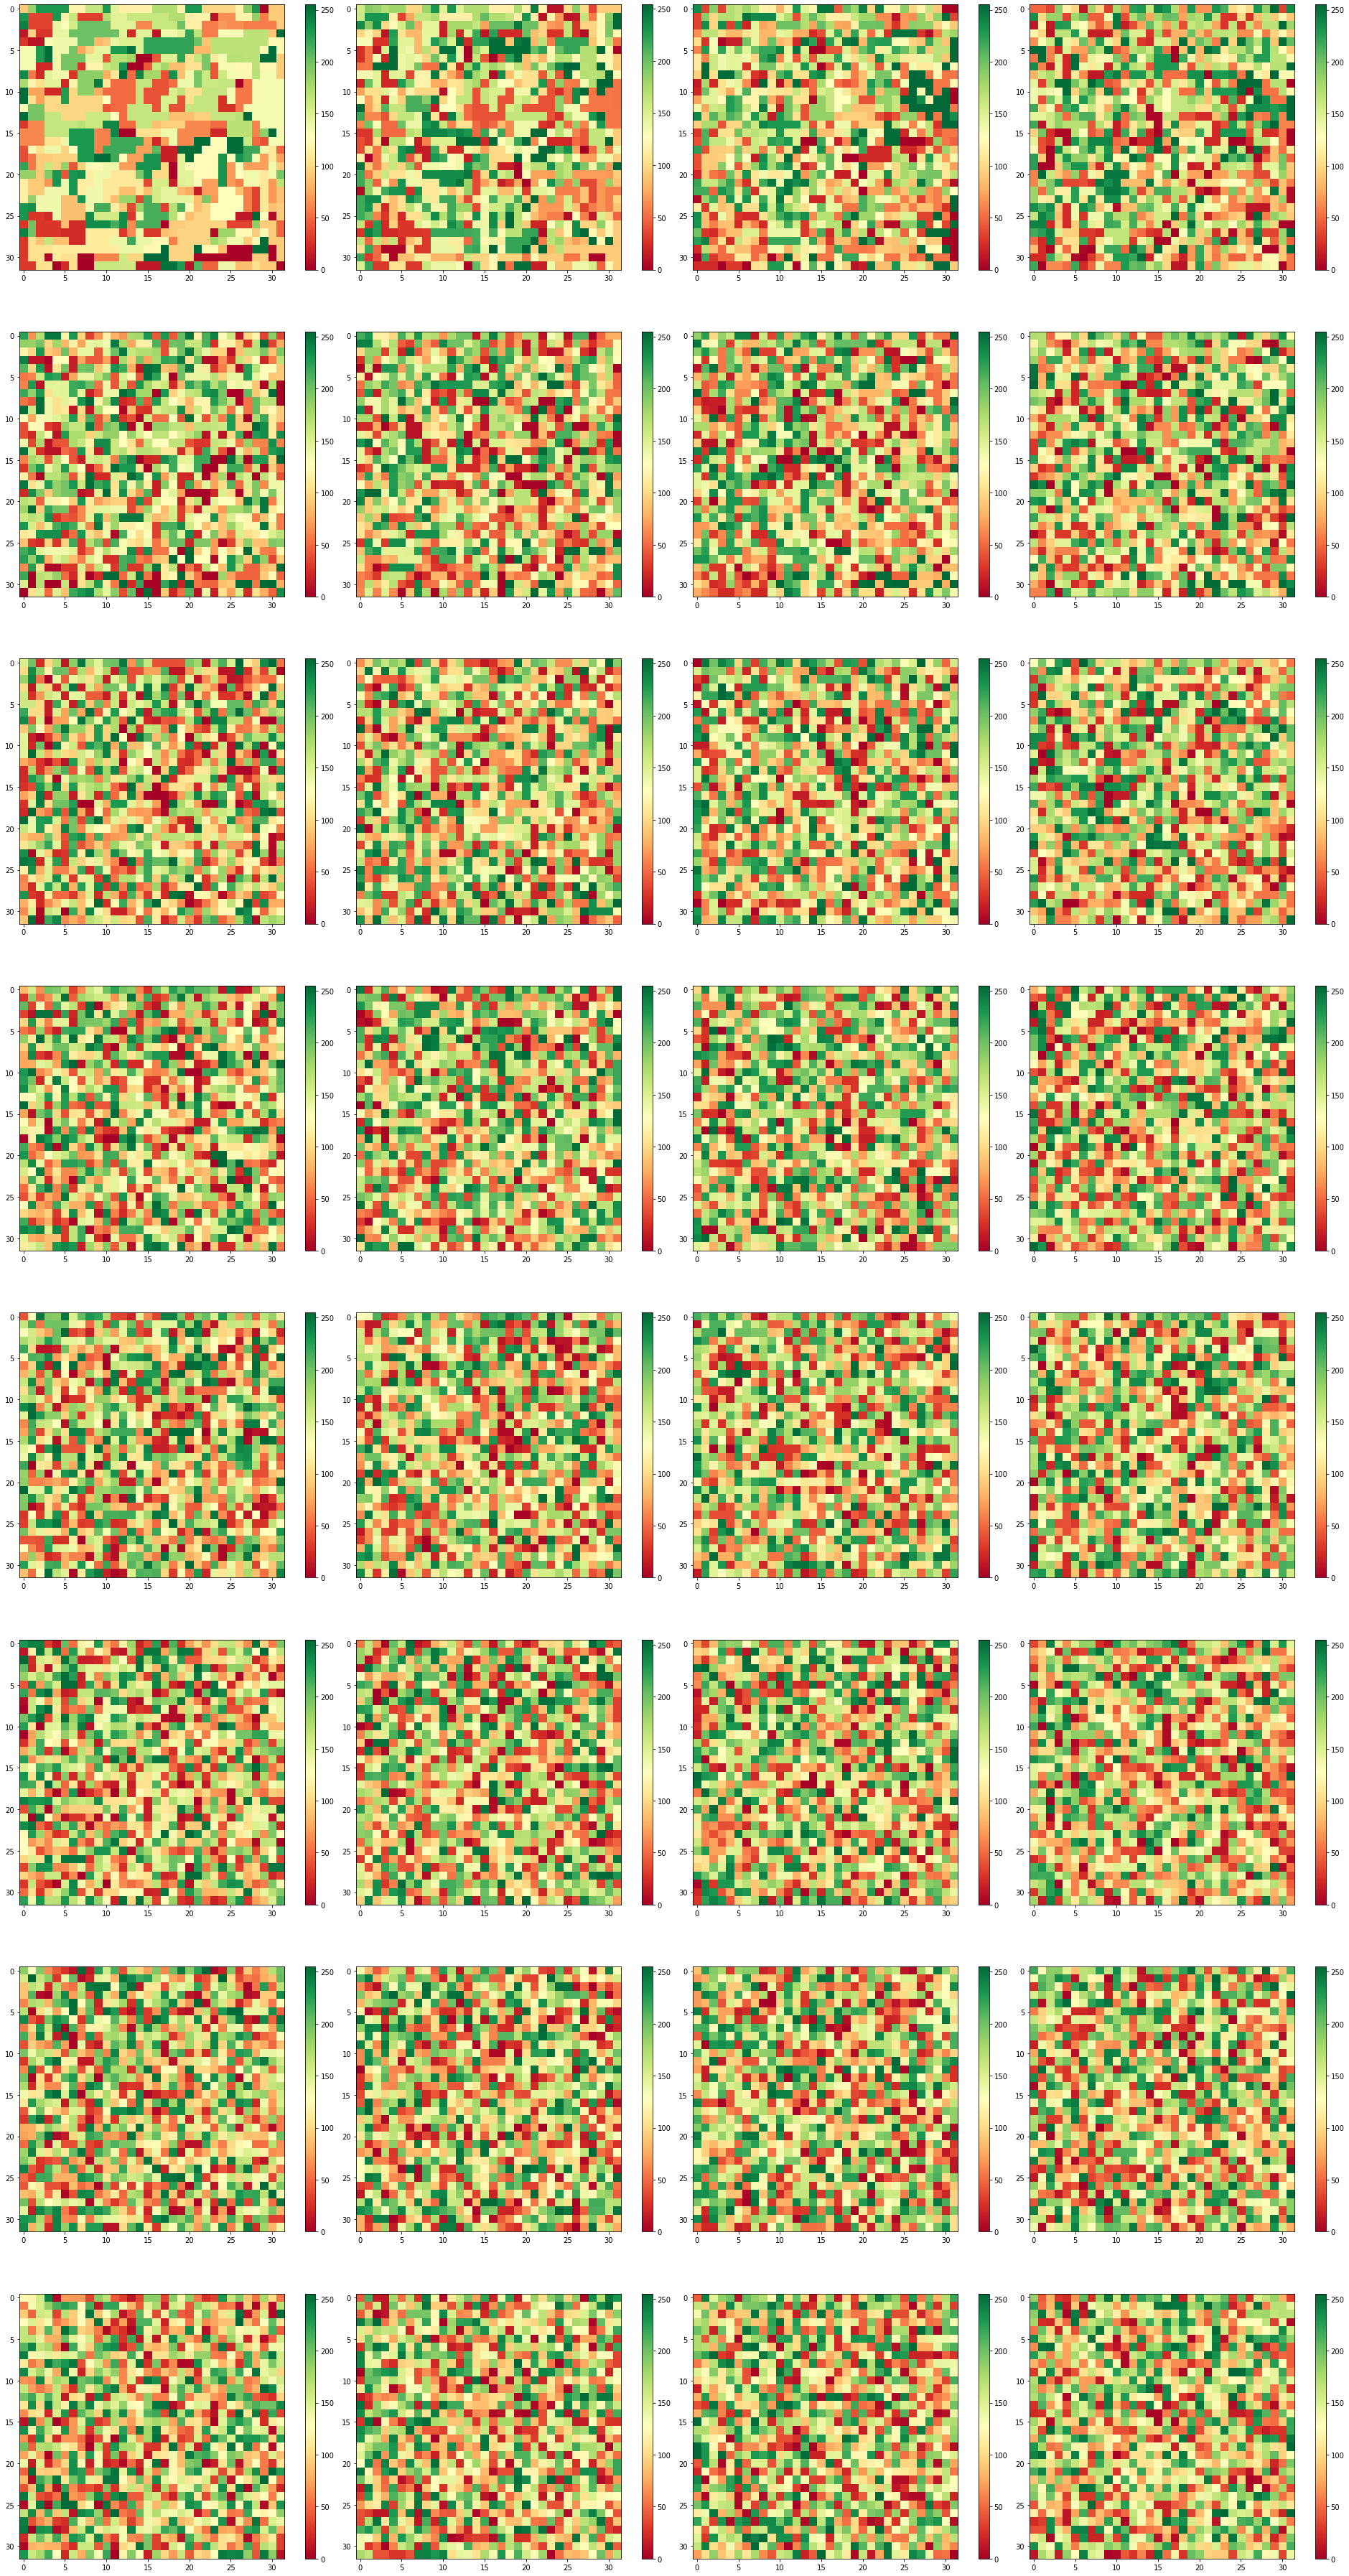

In [20]:
plot(list(descending[:32]), combine='separate', cmap='RdYlGn', colorbar=True)

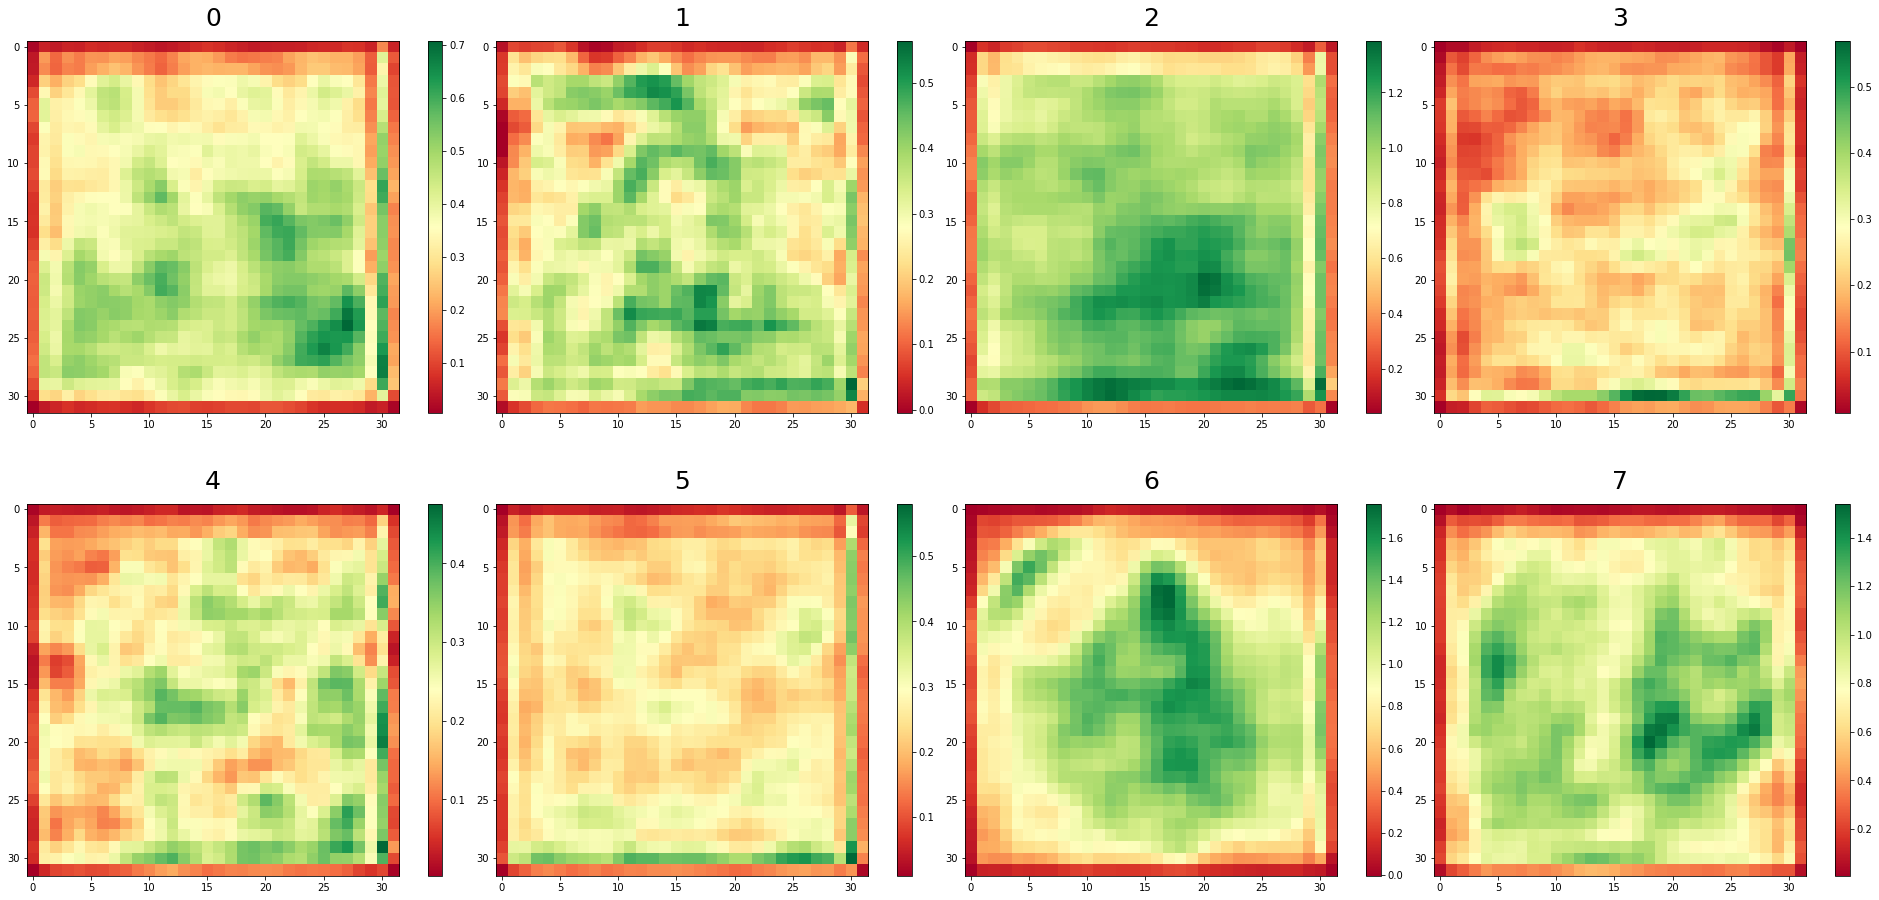

In [21]:
centers = []

for cluster_num in range(n_classes):
    center = clusterer.cluster_centers_[cluster_num]
    full_center = pca.inverse_transform(center)
    full_center = full_center.reshape(256, 32, 32)
    centers.append(full_center[1])

plot(centers, combine='separate', title=list(range(n_classes)), cmap='RdYlGn', colorbar=True)

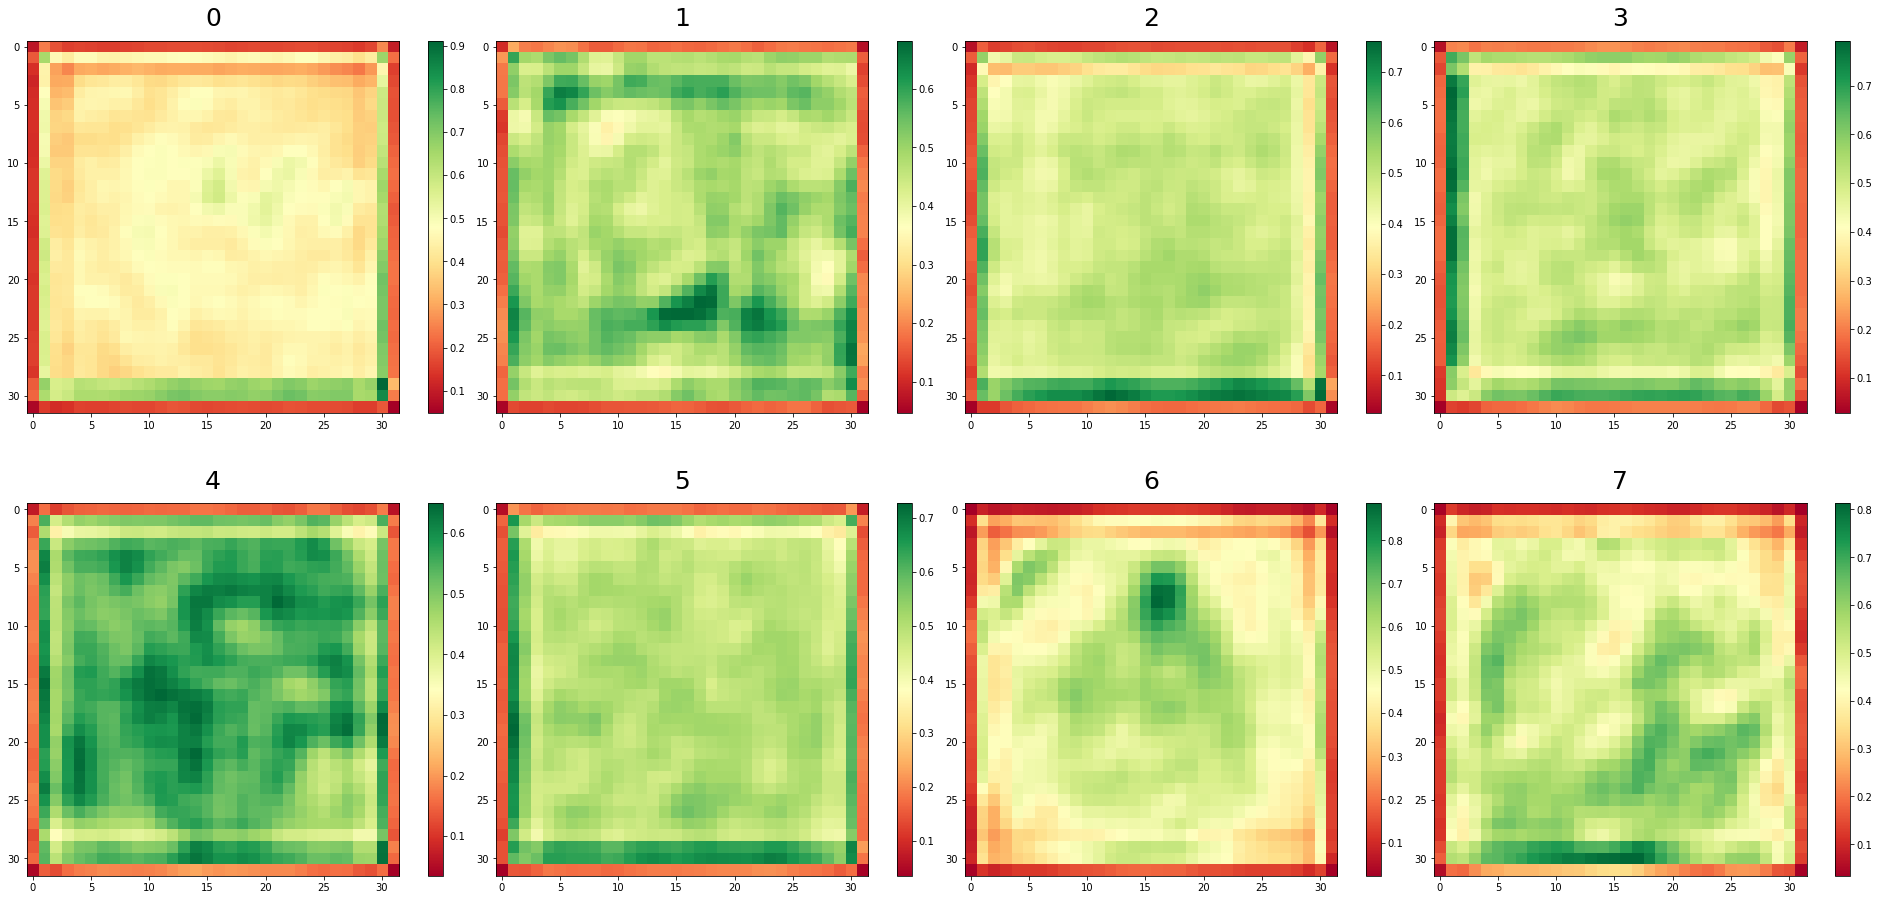

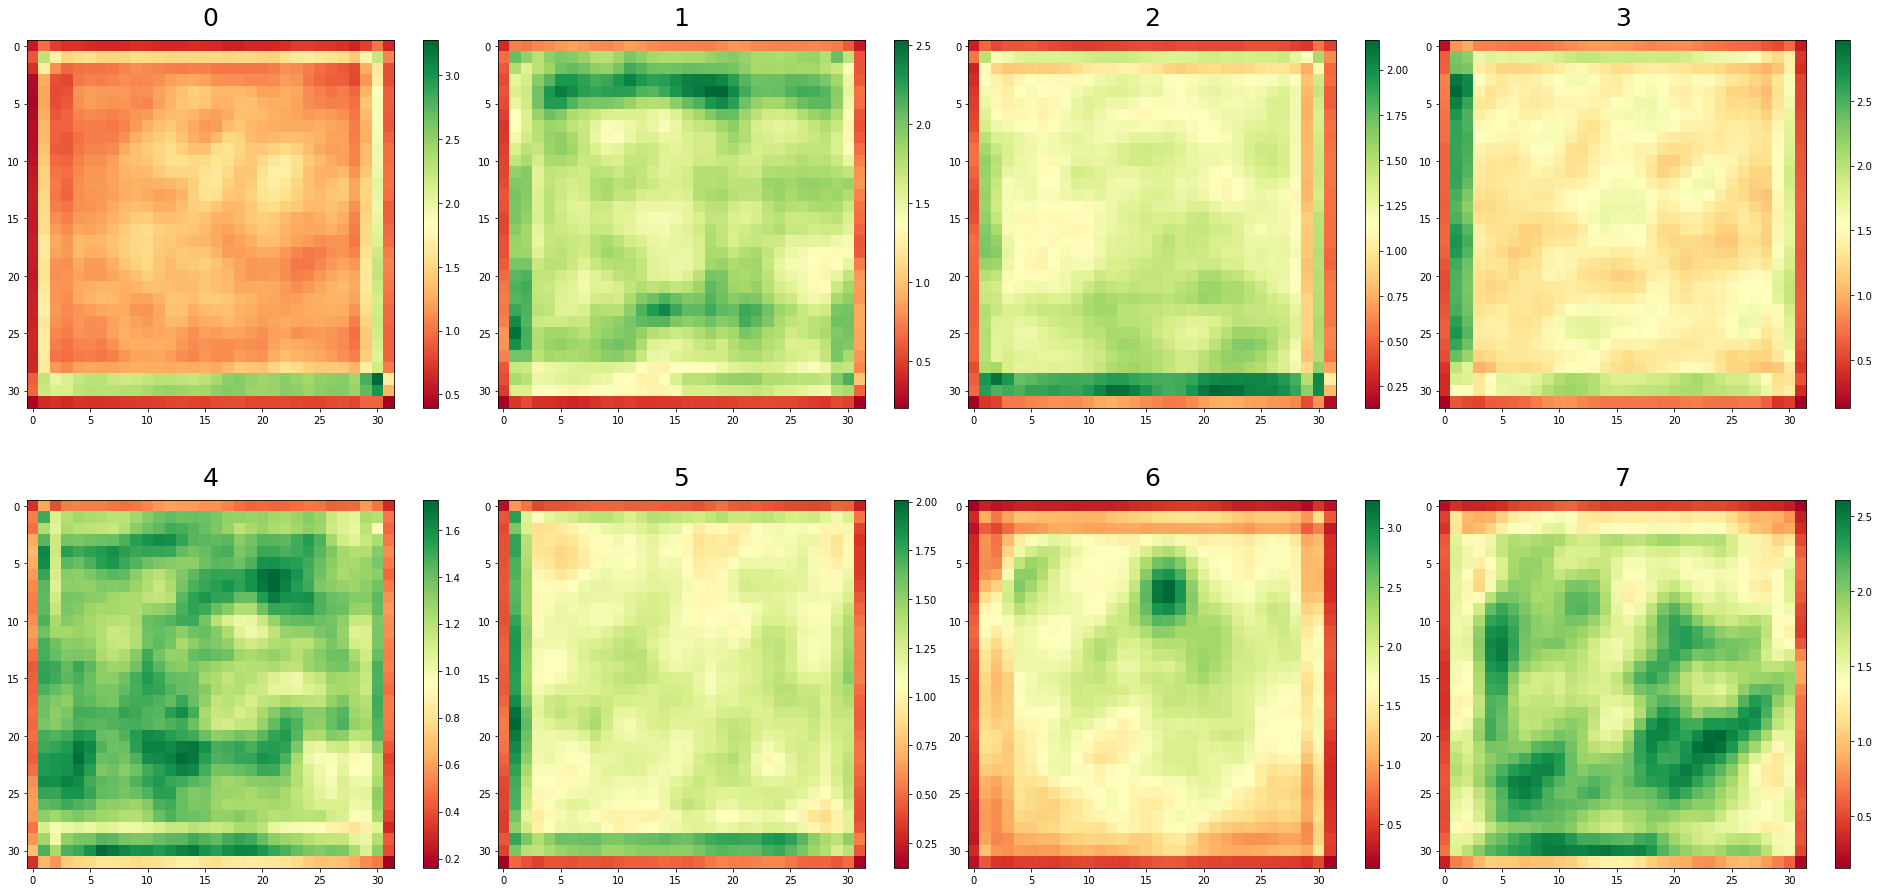

In [22]:
mean_centers = []
max_centers = []

for cluster_num in range(n_classes):
    center = clusterer.cluster_centers_[cluster_num]
    full_center = pca.inverse_transform(center)
    full_center = full_center.reshape(256, 32, 32)

    mean_center = full_center.mean(axis=0)
    mean_centers.append(mean_center)

    max_center = full_center.max(axis=0)
    max_centers.append(max_center)

plot(mean_centers, combine='separate', title=list(range(n_classes)), cmap='RdYlGn', colorbar=True)

plot(max_centers, combine='separate', title=list(range(n_classes)), cmap='RdYlGn', colorbar=True)

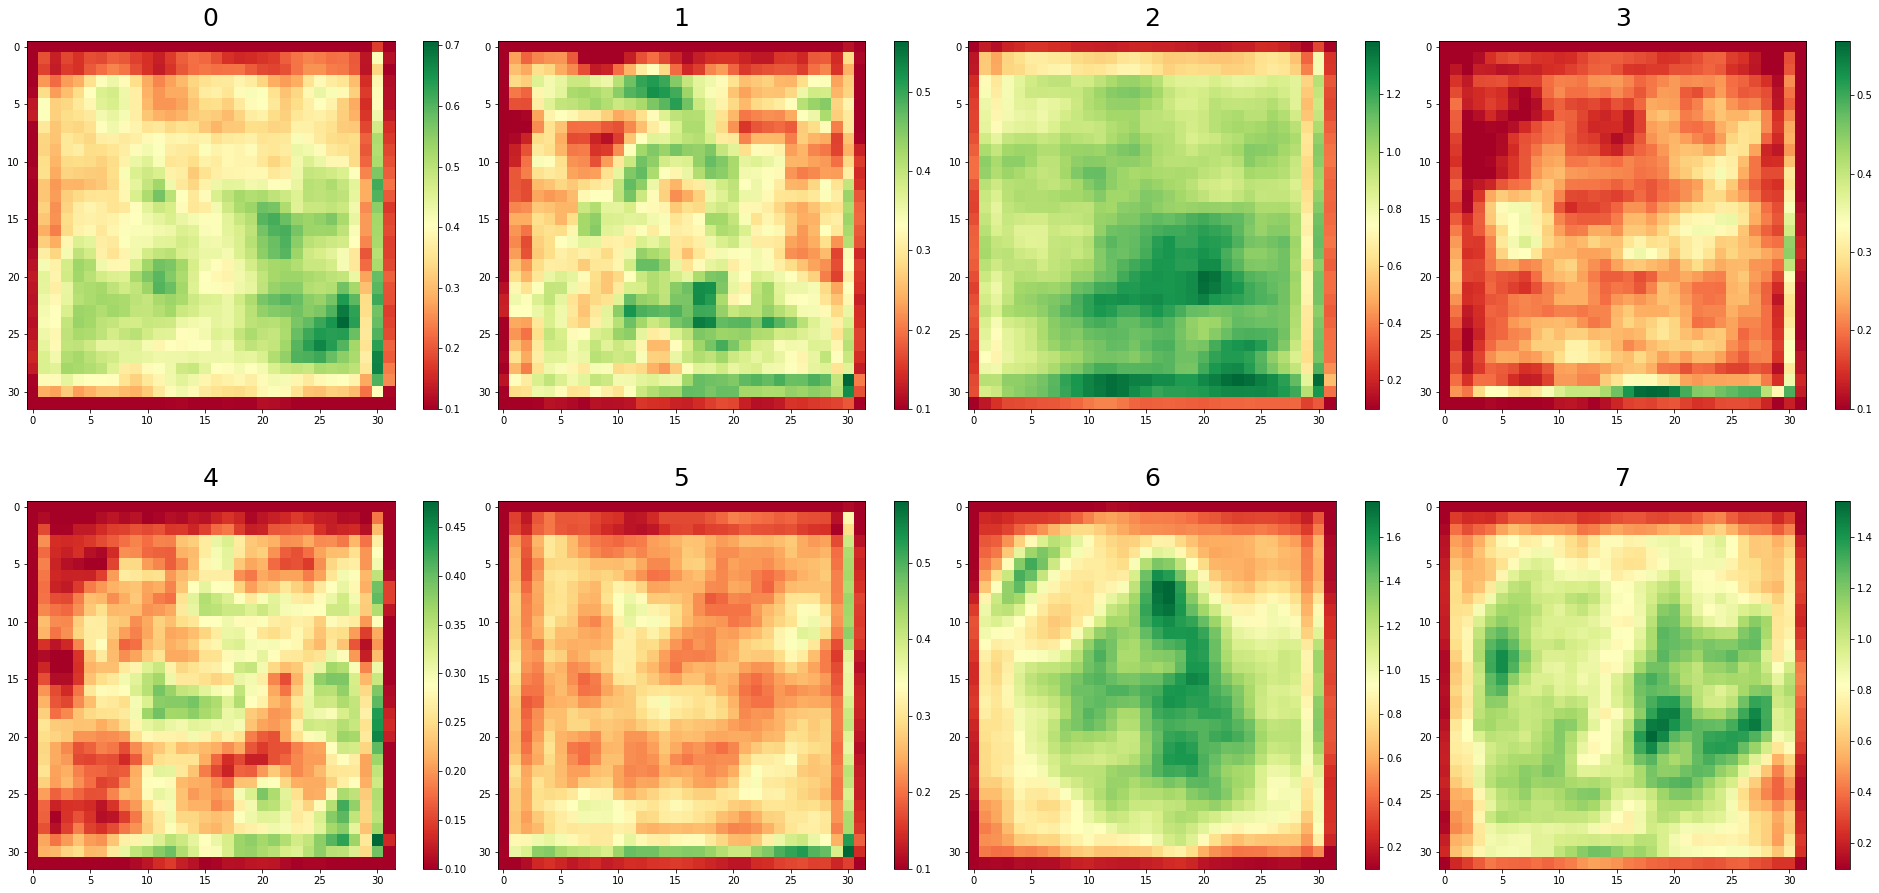

In [23]:
plot(centers, combine='separate', title=list(range(n_classes)), cmap='RdYlGn', colorbar=True, vmin=0.1)

In [24]:
# styles = dataset.label_encoder.inverse_transform(test_labels)
# for cluster_num in range(n_classes):
#     cluster_images = test_batch.images[test_clustered == cluster_num]
#     cluster_images = list(cluster_images.transpose(0, 2, 3, 1))
#     cluster_true_labels = styles[test_clustered == cluster_num].tolist()
#     plot(cluster_images, title=cluster_true_labels, suptitle=f"cluster: {cluster_num}", suptitle_y=1, suptitle_size=30, combine='separate')